<img src=https://learnopencv.com/wp-content/uploads/2024/08/CLIP-Product-Search.png>

## Import Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import multiprocessing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageOps
import pdb
import os
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42
 
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
set_seeds()

# Vision Encoder

<img src=https://learnopencv.com/wp-content/uploads/2023/02/image-1024x538.png>

### Transformer Encoder

In [3]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, mlp_ratio =4):
      super().__init__()

      self.d_model = d_model
      self.n_heads = n_heads

      self.ln1 = nn.LayerNorm(d_model)

      self.mha = MultiheadAttention(d_model, n_heads)

      self.ln2 = nn.LayerNorm(d_model)

      self.mlp = nn.Sequential(
          nn.Linear(d_model, d_model*mlp_ratio),
          nn.GELU(),
          nn.Linear(d_model * mlp_ratio, d_model)
      )

#For clip even though its a encoder model it requires mask ->to account for padded for max seq_length
  def forward(self, x, mask = None):

      x_n = self.mha(self.ln1(x), mask = mask)
      x = x + self.mlp(self.ln2(x_n))

      return x  # x.shape -->  [B,max_seq_len,d_model]

<img src=https://miro.medium.com/v2/resize:fit:720/format:webp/0*N99XOqa8iH4WK_u9>

### Multi Head Attention

In [4]:
class MultiheadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
      super().__init__()

      # d_model --> embed dimension 
      # n_heads --> number of heads 
      self.qkv_dim = d_model //  n_heads #or self.head_size

      self.W_o = nn.Linear(d_model,d_model) #Dense layer

      self.multi_head = nn.ModuleList([AttentionHead(d_model, self.qkv_dim) for _ in range(n_heads)])

  def forward(self,x,mask = None):

       #x.shape --> [B,max_seq_len,d_model]

      #Concatenates the outputs from all attention heads along the last dimension (dim=-1)

      out = torch.cat([head(x, mask=mask) for head in self.multi_head], dim = -1) #  [B,max_seq_len,d_model]

      # Apply the linear transformation
      out = self.W_o(out)   #---> (Concat --> Dense)  -- [B,max_seq_len,d_model]

      return out

### AttentionHead

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*nc_6eJDIlzGTqJAAihLPGA.png">

In [5]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, qkv_dim):
      super().__init__()

      self.qkv_dim = qkv_dim

      self.query = nn.Linear(d_model, qkv_dim)
      self.key = nn.Linear(d_model, qkv_dim)
      self.value = nn.Linear(d_model, qkv_dim)

  def forward(self, x, mask = None):
      # x.shape -->  [B,max_seq_len,d_model]
      Q = self.query(x) #[B,max_seq_len,vit_heads]
      K = self.key(x)
      V = self.value(x)

      attention = Q @ K.transpose(-2,-1) #eg: -2 -second last dim and -1 last dim -->  [B,max_seq_len,max_seq_len]
      #Scaling
      attention = attention / self.qkv_dim ** 0.5  #  [B,max_seq_len,max_seq_len]

      #Apply attention mask for padded sequence
      if mask is not None:
         mask = attention.masked_fill(mask == 0, float("-inf")) # torch.tensor.masked_fill

      # Apply softmax to obtain attention weights [Wij]
      attention  = torch.softmax(attention, dim = -1) #along last dim  # (softmax(Q_K^T)/sqrt(d_k)).V -->  [B,max_seq_len,max_seq_len]

      attention = attention @ V #  [B,max_seq_len,max_seq_len]

      return attention  #Y_i

### Positional Embedding

<img src=https://learnopencv.com/wp-content/uploads/2024/08/Positional-Encoding-ViT-CLIP.png>

In [6]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

### ViT Encoder - Vision Encoder

In [7]:
class VisionEncoder(nn.Module):

    def __init__(self, d_model,img_size,patch_size, n_channels, n_heads,n_layers, emb_dim):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] ==0, "image dimensions should be divisible by patch dim"
        assert d_model % n_heads == 0, "d_model should be divisible by n_heads"

        self.num_patches = (img_size[0] * img_size[1] ) // (patch_size[0] * patch_size[1]) # max_seq_length

        self.max_seq_length = self.num_patches +1

        self.linear_proj = nn.Conv2d(in_channels = n_channels,out_channels = d_model, kernel_size = patch_size[0], stride = patch_size[0])

        self.cls_token = nn.Parameter(torch.randn(1,1,d_model), requires_grad = True)

        self.positional_embedding =  PositionalEmbedding(d_model, self.max_seq_length)

        self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

        self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

    def forward(self,x, mask = None):
       
        x  = self.linear_proj(x)  # (B, C, H, W) -> (B, d_model, Patch_col_d_model, Patch_row_height)  

        x = x.flatten(2).transpose(-2, -1)   # (B, d_model, Patch_col_d_model, Patch_row_height) --> Flatten (B, d_model, Patch) --> .transpose(-2,-1) (B, Patch, d_model)
        
        # The input to the transformer we need to pass a sequence of patches or tokens so we need num_patches to be before hidden dim

        x = torch.cat((self.cls_token.expand(x.shape[0], -1,-1), x), dim = 1) #add cls token at the beginning of patch_sequence   -->  [B,max_seq_len,d_model]

        x =  self.positional_embedding(x)  #  [B,max_seq_len,d_model]

        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x, mask)  #  [B, d_model]

        # Get learned class tokens
        x = x[:, 0, :] 

        # Project to shared embedding space
        if self.projection is not None:
           x  = x  @ self.projection  #[B, emb_dim]

        x  = x  / torch.norm(x , dim = -1 , keepdim = True) 


        return x

# Text Encoder

<img src =https://learnopencv.com/wp-content/uploads/2024/08/CLIP-Tokenization.png>

### Tokenization

In [8]:
def tokenizer(text, encode=True, mask=None, max_seq_length=32):
    if encode:
        # Adding SOT and EOT tokens
        out = chr(2) + text + chr(3)
        
        # Truncate if length exceeds max_seq_length
        if len(out) > max_seq_length:
            out = out[:max_seq_length]
        
        # Add padding if needed
        out = out + "".join([chr(0) for _ in range(max_seq_length - len(out))])
        
        # Encode the text
        out = torch.IntTensor(list(out.encode("utf-8")))
        
        # Create the mask
        mask = torch.ones(len(out.nonzero()))
        
        # Pad the mask to max_seq_length
        if len(mask) < max_seq_length:
            mask = torch.cat((mask, torch.zeros(max_seq_length - len(mask)))).type(torch.IntTensor)
        else:
            mask = mask.type(torch.IntTensor)
    else:
        # Decode the text
        out = [chr(x) for x in text[1:len(mask.nonzero()) - 1]]
        out = "".join(out)
        mask = None

    return out, mask


### Text Encoder

<img src=https://learnopencv.com/wp-content/uploads/2024/08/text-encoding-utf-8-clip-text-encoder-embedding-1.gif>

In [9]:
class TextEncoder(nn.Module):
  def __init__(self, vocab_size, d_model, max_seq_length, n_layers,n_heads, emb_dim):
      super().__init__()

      self.max_seq_length = max_seq_length

      self.embed = nn.Embedding(vocab_size, d_model)

      self.positional_embedding = PositionalEmbedding(d_model, max_seq_length)

      self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

      self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

   # For training
  def forward(self, text, mask = None):

      x = self.embed(text)

      x = self.positional_embedding(x)

      for encoder_layer in self.transformer_encoder:
          x = encoder_layer(x, mask=mask)

      #The output of the encoder layers is the text features. We are going to be using the features from the EOT embedding.

      x = x[torch.arange(text.shape[0]), torch.sub(torch.sum(mask[:,0],dim=1),1)]

      if self.projection is not None:
         x = x @ self.projection

      x = x / torch.norm(x, dim=-1, keepdim = True)

      return x


In [10]:
class TextEncoder_Retrieval(nn.Module):
  def __init__(self, vocab_size, d_model, max_seq_length, n_layers,n_heads, emb_dim):
      super().__init__()

      self.max_seq_length = max_seq_length

      self.embed = nn.Embedding(vocab_size, d_model)

      self.positional_embedding = PositionalEmbedding(d_model, max_seq_length)

      self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

      self.projection = nn.Parameter(torch.randn(d_model, emb_dim))


 # # For image retrieval
  def forward(self, text, mask=None):
        x = self.embed(text)
        x = self.positional_embedding(x)
    
        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x, mask=mask)
    
        if mask is not None:
            # Get the lengths of each sequence (i.e., find the last non-padded token)
            seq_lengths = mask.sum(dim=1) - 1  # Subtract 1 to get the index
            x = x[torch.arange(text.shape[0]), seq_lengths]
        else:
            x = x[:, -1]  # If no mask is provided, take the last token in the sequence.
    
        if self.projection is not None:
            x = x @ self.projection
    
        x = x / torch.norm(x, dim=-1, keepdim=True)
    
        return x

# CLIP

<img src=https://learnopencv.com/wp-content/uploads/2024/08/CLIP-Architecture-Explained-OpenAI.png>

In [11]:
class CLIP(nn.Module):

    def __init__(self, emb_dim, vit_layers, vit_d_model, img_size, patch_size, n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers, text_d_model, retrieval = False):
        super().__init__()

        self.vision_encoder = VisionEncoder(vit_d_model, img_size, patch_size, n_channels, vit_heads, vit_layers, emb_dim)
        # print(retrieval)
        if retrieval:
            self.text_encoder = TextEncoder_Retrieval(vocab_size, text_d_model, max_seq_length, text_layers, text_heads, emb_dim)
        else:
            self.text_encoder = TextEncoder(vocab_size, text_d_model, max_seq_length, text_layers, text_heads, emb_dim)
            
        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def CLIPLoss(self, logits, device = "cuda"):
        #Symmetric or Contrastive loss
    # arange generates a list between 0 and n-1
        labels = torch.arange(logits.shape[0]).to(device)  # For row 1 we want 1,1 to be max, and row n-1 we want (n-1,n-1) text pairs to be max --> time 15.43 umar

        loss_v = nn.functional.cross_entropy(logits.transpose(-2,-1), labels)

        loss_t = nn.functional.cross_entropy(logits, labels)
        loss = (loss_v + loss_t) / 2

        return loss

    def forward(self, image, text, mask=None):
        V_e = self.vision_encoder(image)  # Vision encoder output [B, emb_dim]
        T_e = self.text_encoder(text, mask)  # Text encoder output [B, emb_dim]
        # print(f"V_e shape: {V_e.shape}, T_e shape: {T_e.shape}")

        logits = (V_e @ T_e.transpose(-2, -1)) * torch.exp(self.temperature)
        
        loss = self.CLIPLoss(logits, self.device)
        
        return loss

In [12]:
# Vision
emb_dim = 128 
vit_d_model = 32 # vit_heads * vit_layers = vit_d_model
img_size = (80,80)
patch_size = (5,5) 
n_channels = 3
vit_layers = 8
vit_heads = 4 

# Text
vocab_size = 256
text_d_model = 64 #  -->  text_heads * text_layers = text_d_model
max_seq_length = 128
text_heads = 8
text_layers = 8
lr = 1e-3
epochs = 7
batch_size = 128
# nw = 8
nw = multiprocessing.cpu_count()

# DATASET PREPARATION

<img src=https://learnopencv.com/wp-content/uploads/2024/08/CLIP-Text2Img-Retrieval-Embedding0Product-Search-Fashion.gif>

In [13]:
# !kaggle datasets download -d paramaggarwal/fashion-product-images-small -q
# !ls -l

In [14]:
# Load the dataset
df = pd.read_csv('myntradataset/styles.csv', usecols=['id',  'subCategory'])
print(df.shape)
unique, counts = np.unique(df["subCategory"].tolist(), return_counts = True)
print(f"Classes: {unique}: {counts}")

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.10, random_state=42)

# Print the sizes of the datasets
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")
class_names = df['subCategory'].unique()
class_names = [str(name).lower() for name in class_names]

# Replace in-place
for i, name in enumerate(class_names):
    if name == "lips":
        class_names[i] = "lipstick"
    elif name == "eyes":
        class_names[i] = "eyelash"
    elif name == "nails":
        class_names[i] = "nail polish"

captions = {idx: class_name for idx, class_name in enumerate(class_names)}

(44446, 2)
Classes: ['Accessories' 'Apparel Set' 'Bags' 'Bath and Body' 'Beauty Accessories'
 'Belts' 'Bottomwear' 'Cufflinks' 'Dress' 'Eyes' 'Eyewear' 'Flip Flops'
 'Fragrance' 'Free Gifts' 'Gloves' 'Hair' 'Headwear' 'Home Furnishing'
 'Innerwear' 'Jewellery' 'Lips' 'Loungewear and Nightwear' 'Makeup'
 'Mufflers' 'Nails' 'Perfumes' 'Sandal' 'Saree' 'Scarves'
 'Shoe Accessories' 'Shoes' 'Skin' 'Skin Care' 'Socks'
 'Sports Accessories' 'Sports Equipment' 'Stoles' 'Ties' 'Topwear'
 'Umbrellas' 'Vouchers' 'Wallets' 'Watches' 'Water Bottle' 'Wristbands']: [  143   106  3055    12     4   811  2694   108   478    43  1073   915
  1012   104    20    19   293     1  1808  1080   527   470   307    38
   329     6   963   427   118    24  7344    69    77   698     3    21
    90   258 15405     6     1   933  2542     7     4]
Train size: 40001, Validation size: 4445


In [15]:
class MyntraDataset(Dataset):
    def __init__(self, data_frame, captions, target_size=28):
        
        self.data_frame = data_frame[data_frame['subCategory'].str.lower() != 'innerwear']
        self.target_size = target_size  # Desired size for the square image
        self.transform = T.Compose([
            T.ToTensor()  # Convert image to tensor
        ])

        self.captions = captions

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        while True:
            sample = self.data_frame.iloc[idx]
            img_path = os.path.join("myntradataset/images", f"{sample['id']}.jpg")
            try:
                # Attempt to open the image
                image = Image.open(img_path).convert('RGB')
            except (FileNotFoundError, IOError):
                # If the image is not found, skip this sample by incrementing the index
                idx = (idx + 1) % len(self.data_frame)  # Loop back to the start if we reach the end
                continue  # Retry with the next index
            # Resize the image to maintain aspect ratio
            image = self.resize_and_pad(image, self.target_size)
            # Apply transformations (convert to tensor)
            image = self.transform(image)
            # Retrieve the subCategory label and its corresponding caption
            label = sample['subCategory'].lower()
            label = {"lips": "lipstick", "eyes": "eyelash", "nails": "nail polish"}.get(label, label)
            label_idx = next(idx for idx, class_name in self.captions.items() if class_name == label)
            # # Tokenize the caption using the tokenizer function
            cap, mask = tokenizer(self.captions[label_idx])
            # Make sure the mask is a tensor
            mask = torch.tensor(mask)
            # If the mask is a single dimension, make sure it is expanded correctly
            if len(mask.size()) == 1:
                mask = mask.unsqueeze(0)
            return {"image": image, "caption": cap, "mask": mask,"id": img_path}

    def resize_and_pad(self, image, target_size):
        original_width, original_height = image.size
        aspect_ratio = original_width / original_height
        if aspect_ratio > 1:
            new_width = target_size
            new_height = int(target_size / aspect_ratio)
        else:
            new_height = target_size
            new_width = int(target_size * aspect_ratio)
        image = image.resize((new_width, new_height))
        
        pad_width = (target_size - new_width) // 2
        pad_height = (target_size - new_height) // 2
        
        padding = (pad_width, pad_height, target_size - new_width - pad_width, target_size - new_height - pad_height)
        image = ImageOps.expand(image, padding, fill=(0, 0, 0))
        
        return image

In [16]:
#Create datasets
train_dataset = MyntraDataset(data_frame=train_df ,captions = captions, target_size =80)
val_dataset = MyntraDataset(data_frame=val_df ,captions = captions ,target_size =80)
test_dataset = MyntraDataset(data_frame=val_df, captions = captions, target_size = 224)
print("Number of Samples in Train Dataset:", len(train_dataset))
print("Number of Samples in Validation Dataset:", len(val_dataset))

Number of Samples in Train Dataset: 38360
Number of Samples in Validation Dataset: 4278


In [17]:
train_loader = DataLoader(
  dataset=train_dataset,
  shuffle=True,
  batch_size=batch_size,
  num_workers=nw,
)

val_loader  = DataLoader(
  dataset=val_dataset, 
  shuffle=False,
  batch_size=batch_size, 
  num_workers=nw,
)

test_loader  = DataLoader(
  dataset=test_dataset, 
  shuffle=False, 
  batch_size=batch_size, 
  num_workers=nw,
)

#Sanity check of dataloader initialization
len(next(iter(train_loader)))  #(img_tensor,label_tensor)

4

In [18]:
# Function to visualize a batch of images with their class names
def visualize_samples(dataset, tokenizer, num_samples=5):
    # Get a batch of samples
    for i in range(num_samples):
        sample = dataset[i]  # Access the ith sample in the dataset
        image = sample['image']
        tokenized_caption = sample['caption']
        mask = sample['mask'][0]
        
        # Decode the tokenized caption to get the original class name
        original_caption = tokenizer(tokenized_caption, encode=False, mask=mask)[0]
        
        # Convert the tensor image back to a PIL image for visualization
        image = T.ToPILImage()(image)
        
        # Display the image
        plt.figure(figsize=(4, 4))
        plt.imshow(image,cmap="gray")
        plt.title(f"Class: {original_caption}")  # Display the non-tokenized class name as title
        plt.axis('off')
        plt.show()

# Visualize samples from the train dataset
# visualize_samples(train_dataset, tokenizer, num_samples=5)

# Training CLIP

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIP(emb_dim, vit_layers, vit_d_model, img_size,patch_size,n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers,text_d_model, retrieval = False).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [20]:
total_params = 0
total_params = sum([ param.numel() for param in model.parameters() if param.requires_grad])
print(f"Total number of trainable parameters: {total_params}; i.e., {total_params/1000000:.2f} M")

Total number of trainable parameters: 532641; i.e., 0.53 M


In [21]:
best_loss = np.inf
for epoch in range(epochs):
    epoch_loss = 0.0  # To accumulate the loss over the epoch
    with tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch [{epoch+1}/{epochs}]") as tepoch:
        # print(tepoch)
        for i, data in tepoch:
            # print(i, data)
            img, cap, mask = data["image"].to(device), data["caption"].to(device), data["mask"].to(device)
            optimizer.zero_grad()
            loss = model(img, cap, mask)
            loss.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            tepoch.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.3f}")

    # Save model if it performed better than the previous best
    if avg_loss <= best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "clip.pt")
        print("Model Saved.")

Epoch [1/7]: 100%|██████████| 300/300 [09:32<00:00,  1.91s/it, loss=3.24]

Epoch [1/7], Average Loss: 4.324
Model Saved.



Epoch [2/7]: 100%|██████████| 300/300 [09:31<00:00,  1.91s/it, loss=2.96]

Epoch [2/7], Average Loss: 3.481
Model Saved.



Epoch [3/7]: 100%|██████████| 300/300 [09:31<00:00,  1.91s/it, loss=2.8] 

Epoch [3/7], Average Loss: 3.320
Model Saved.



Epoch [4/7]: 100%|██████████| 300/300 [09:31<00:00,  1.91s/it, loss=2.96]

Epoch [4/7], Average Loss: 3.246
Model Saved.



Epoch [5/7]: 100%|██████████| 300/300 [09:31<00:00,  1.91s/it, loss=2.76]

Epoch [5/7], Average Loss: 3.195
Model Saved.



Epoch [6/7]: 100%|██████████| 300/300 [09:35<00:00,  1.92s/it, loss=2.73]

Epoch [6/7], Average Loss: 3.146
Model Saved.



Epoch [7/7]: 100%|██████████| 300/300 [09:31<00:00,  1.91s/it, loss=2.71]

Epoch [7/7], Average Loss: 3.121
Model Saved.


# Validating CLIP

In [22]:
# Loading Best Model
model = CLIP(
    emb_dim, 
    vit_layers, 
    vit_d_model, 
    img_size,
    patch_size,
    n_channels,
    vit_heads,
    vocab_size,
    max_seq_length,
    text_heads,
    text_layers,
    text_d_model,
    retrieval=False,
).to(device)

model.load_state_dict(torch.load("clip.pt", map_location=device))

text = torch.stack([tokenizer(x)[0] for x in val_dataset.captions.values()]).to(device)

mask = torch.stack([tokenizer(x)[1] for x in val_dataset.captions.values()])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

correct, total = 0,0
with torch.no_grad():
    for data in val_loader:
        
        images, labels = data["image"].to(device), data["caption"].to(device)
        image_features = model.vision_encoder(images)
        text_features = model.text_encoder(text, mask=mask)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        _, indices = torch.max(similarity,1)
   
        pred = torch.stack([tokenizer(val_dataset.captions[int(i)])[0] for i in indices]).to(device)
        correct += int(sum(torch.sum((pred==labels),dim=1)//len(pred[0])))
        
        total += len(labels)

print(f'\nModel Accuracy: {100 * correct // total} %')


Model Accuracy: 72 %


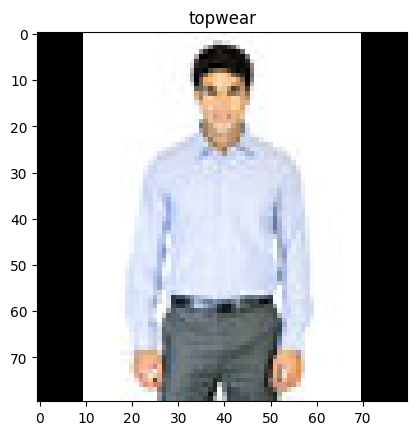


Top predictions:

         Topwear: 68.44%
          Stoles: 31.56%
     Apparel Set: 0.00%
    Water Bottle: 0.00%
           Dress: 0.00%


In [23]:
class_names = df['subCategory'].unique()
class_names = [str(name) for name in class_names]

text = torch.stack([tokenizer(x)[0] for x in class_names]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in class_names])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

idx = 904

img = val_dataset[idx]["image"][None,:]
plt.imshow(img[0].permute(1, 2, 0)  ,cmap="gray")
plt.title(tokenizer(val_dataset[idx]["caption"], encode=False, mask=val_dataset[idx]["mask"][0])[0])
plt.show()
img = img.to(device)
with torch.no_grad():
  image_features = model.vision_encoder(img)
  text_features = model.text_encoder(text, mask=mask)

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")

## Text to Image Retrieval with CLIP - E-commerce


Top 10 images for query 'bags':

Similarity: 1.13%


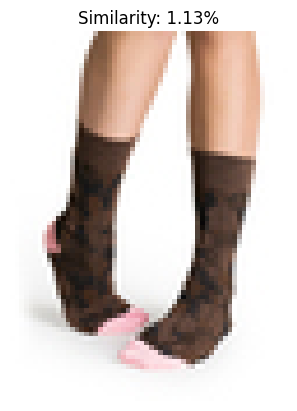

Similarity: 0.51%


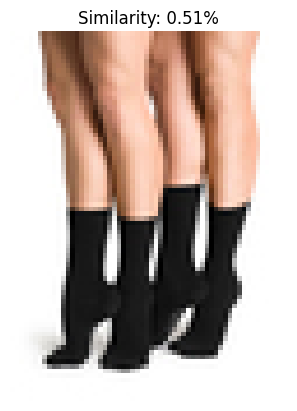

Similarity: 0.50%


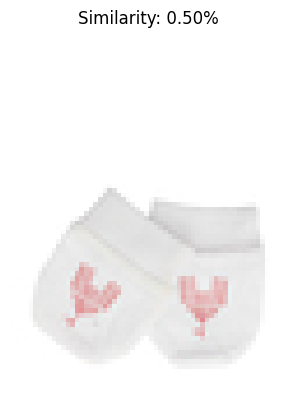

Similarity: 0.46%


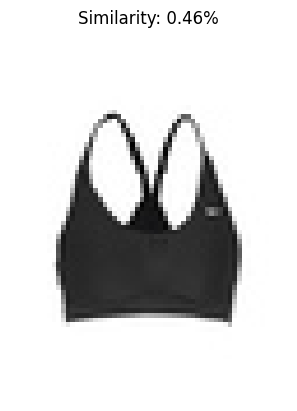

Similarity: 0.45%


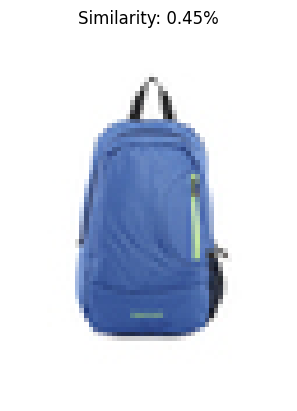

Similarity: 0.45%


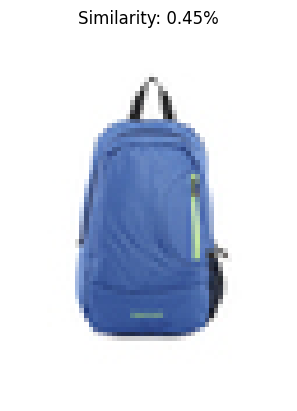

Similarity: 0.45%


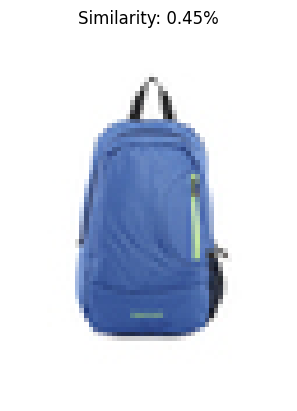

Similarity: 0.45%


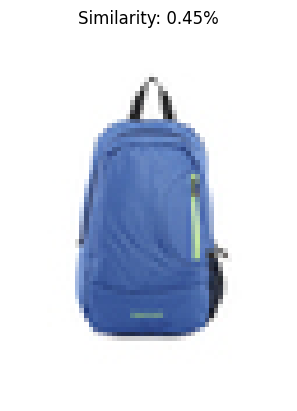

Similarity: 0.45%


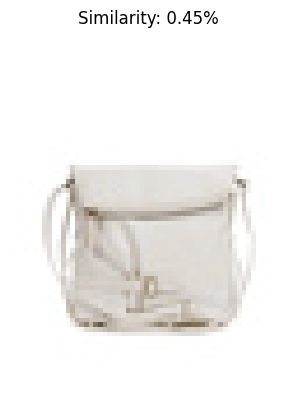

Similarity: 0.43%


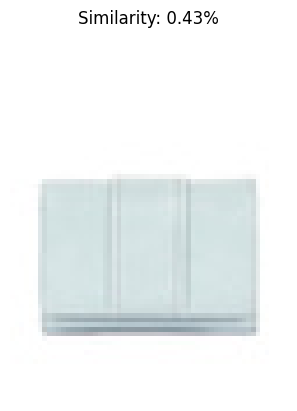

In [25]:
retrieval_model = CLIP(
    emb_dim, 
    vit_layers, 
    vit_d_model, 
    img_size,
    patch_size,
    n_channels, 
    vit_heads, 
    vocab_size, 
    max_seq_length, 
    text_heads, 
    text_layers,
    text_d_model,
    retrieval=True,
).to(device)

retrieval_model.load_state_dict(torch.load("clip.pt", map_location=device))


# Step 1: Encode the text query using your tokenizer and TextEncoder
query = "bags"
query_text, query_mask = tokenizer(query)
query_text = query_text.unsqueeze(0).to(device)  # Add batch dimension
query_mask = query_mask.unsqueeze(0).to(device)

with torch.no_grad():
    query_features = retrieval_model.text_encoder(query_text, mask=query_mask)
    query_features /= query_features.norm(dim=-1, keepdim=True)

# Step 2: Encode all images in the dataset and store features
image_features_list = []
image_paths = []

# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5) # orig
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=5)

with torch.no_grad():
    for batch in val_loader:
        # print(batch)
        images = batch["image"].to(device)
        features = retrieval_model.vision_encoder(images)
        features /= features.norm(dim=-1, keepdim=True)
        
        image_features_list.append(features)
        image_paths.extend(batch["id"])  # Assuming batch contains image paths or IDs

# Concatenate all image features
image_features = torch.cat(image_features_list, dim=0)

# Step 3: Compute similarity using the CLIP model's logic
# In your CLIP model, this is done using logits and temperature scaling
similarities = (query_features @ image_features.T) * torch.exp(model.temperature)

# Apply softmax to the similarities if needed
similarities = similarities.softmax(dim=-1)

# Retrieve top 5 matches
TOP_K: int=10
top_values, top_indices = similarities.topk(TOP_K)

# Step 4: Retrieve and display top N images
print(f"\nTop {TOP_K} images for query '{query}':\n")
for value, index in zip(top_values[0], top_indices[0]):
    print(f"Similarity: {100 * value.item():.2f}%")
    img_path = image_paths[index]
    
    # Display the image
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.title(f"Similarity: {100 * value.item():.2f}%")
    plt.axis('off')
    plt.show()
